# **Clasificación de imágenes con una red neuronal convolucional (CNN)**

A continuación, construiremos una red neuronal para hacer un OCR (Optical Character Recognition) sencillo.
En este tipo de problema el sistema tiene que reconocer automáticamente caracteres manuscritos que han sido escaneados.
Usaremos una base de datos de prueba muy famosa históricamente en el campo del Deep Learning, la base de datos MNIST.

Lo primero que haremos será importar las librerías que vamos a utilizar, cargar el dataset y mostrar las estadísticas de frecuencias de clases:

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import plot_model
from sklearn.model_selection import train_test_split
from matplotlib.ticker import MaxNLocator

In [ ]:
# Cargamos MNIST (viene ya dividido en training y test):

(X_tr, y_tr), (X_te, y_te) = mnist.load_data()

11490434/11490434 [==============================] - 0s 0us/step


In [ ]:
# Separamos una parte de training (el 30%) para validación:

aux = train_test_split(X_tr, y_tr, test_size=0.3,
                       stratify=y_tr, random_state=1)
X_tr, X_va, y_tr, y_va = aux

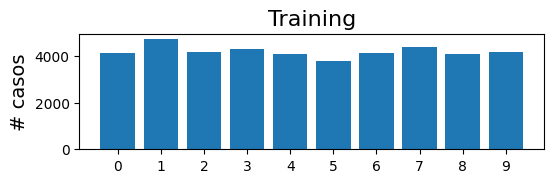

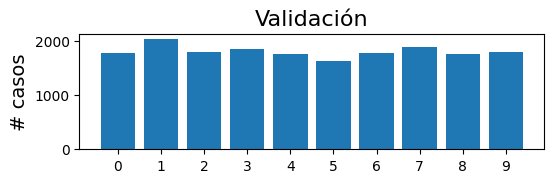

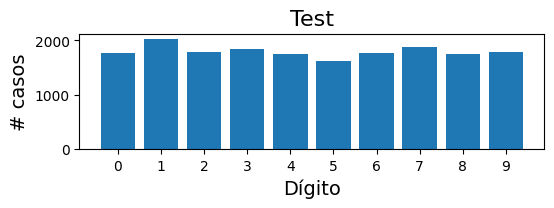

In [ ]:
def muestra_estadisticas(y, title, xlabel=""):
    clases, counts = np.unique(y, return_counts=True)
    plt.figure(figsize=(6,1.5))
    plt.bar(clases, counts)
    plt.title(title, fontsize=16)
    if xlabel:
        plt.xlabel(xlabel, fontsize=14)
    plt.ylabel("# casos", fontsize=14)
    plt.xticks(clases)
    plt.show()

muestra_estadisticas(y_tr, title="Training")
muestra_estadisticas(y_va, title="Validación")
muestra_estadisticas(y_va, title="Test", xlabel="Dígito")

In [ ]:
print(X_tr.shape)
print(X_va.shape)
print(X_te.shape)

(42000, 28, 28)
(18000, 28, 28)
(10000, 28, 28)


Como podemos observar, el problema consta de 10 clases que tienen frecuencias muy parecidas.
Por las dimensiones de los arrays vemos que en training hay 42000 imágenes, en validación 18000 y en test 10000, todas de 28x28 píxeles.
Ahora chequearemos el mínimo y máximo del valor de dichos dígitos:

In [ ]:
for X in [X_tr, X_va, X_te]:
    print(X.min(), X.max())

0 255
0 255
0 255


Vemos que el rango de valores en los píxeles va de 0 a 255, lo que puede causar problemas en la construcción de la red, por lo que los normalizaremos para que estén entre 0 y 1:

In [ ]:
X_tr = X_tr / 255
X_va = X_va / 255
X_te = X_te / 255

Ahora vamos a mostrar algunos de los dígitos de training.
Para ello usaremos el mapa de color “gray_r”, donde los píxeles oscuros corresponden a valores normalizados de píxel cercanos a uno, y los píxeles blancos corresponden a valores cercanos a cero.
Los grises corresponden a niveles intermedios.

In [ ]:
def plot_image(image, cmap="binary"):
    plt.imshow(image, cmap=cmap)
    plt.axis("off")    

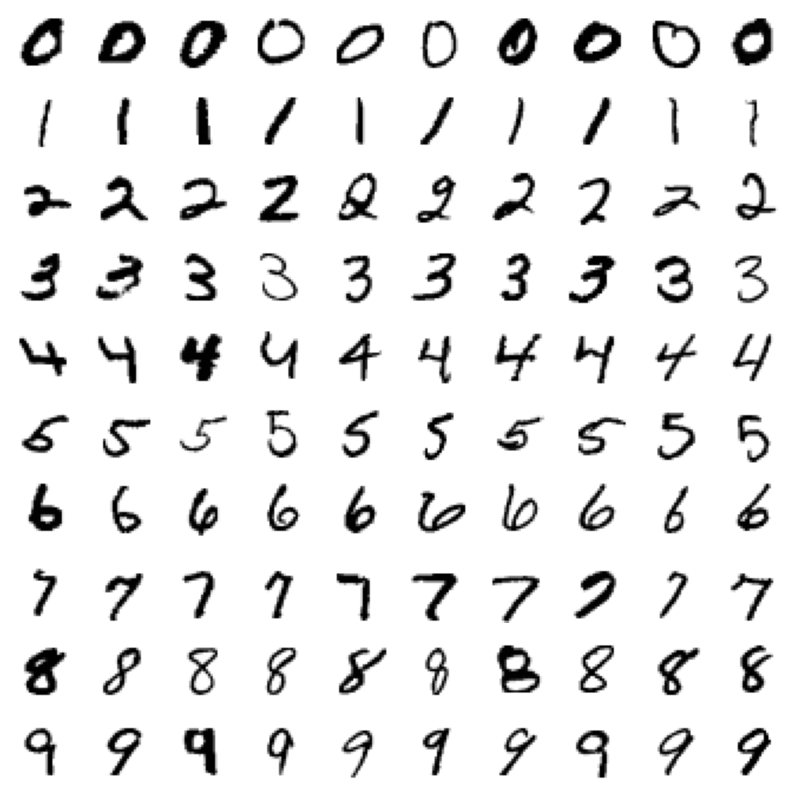

In [ ]:
plt.figure(figsize=(10,10))
i=1
for clase in range(10):
    indices = np.where(y_tr==clase)[0][:10]
    for indice in indices:
        plt.subplot(10,10,i)
        plt.imshow(X_tr[indice], cmap="gray_r")
        plt.axis("off")
        i=i+1

El siguiente paso es definir la red convolucional.
En la capa de entrada (Input) se especifica el tamaño de las imágenes (28,28,1), ya que son de 28x28 píxeles y tienen 1 solo valor por píxel al ser imágenes en blanco y negro (un solo canal).
A continuación, está la fase de extracción de características formada por 2 pares convolución-maxpooling; la capa de aplanado (Flatten), que prepara los datos para la siguiente fase (la de decisión); y esta fase, que consta de una capa densa oculta y otra de salida.
La capa de salida tiene 10 neuronas ya que hay 10 clases diferentes.
Cada una de ellas estima la probabilidad de que la imagen sea un dígito concreto.
El tipo de neurona es softmax para que la suma de las salidas de esas diez neuronas sea uno.

In [ ]:
model = keras.Sequential([
    # Capa de entrada:
    layers.Input(shape=(28,28,1)),

    # Fase de extracción de características:
    layers.Conv2D(filters=4, kernel_size=(3,3),
                  activation="relu", name="Convolucional_1"),
    layers.MaxPool2D(pool_size=(2,2), name="MaxPooling_1"),
    layers.Conv2D(filters=8, kernel_size=(3,3),
                  activation="relu", name="Convolucional_2"),
    layers.MaxPool2D(pool_size=(2,2), name="MaxPooling_2"),

    # Capa de aplanado:
    layers.Flatten(name="Aplanado"),
    
    # Fase de decisión:
    layers.Dense(units=16, activation="relu",
                 name="Densa_oculta"),
    layers.Dense(units=10, activation="softmax",
                 name="Salida")
])

Como vemos, cada una de las capas convolucionales tiene asociado el número de filtros (kernels), y el tamaño de estos. Por otra parte, las capas de maxpooling especifican un tamaño de grupo de 2x2, por lo que reducen en un factor 2 tanto la anchura como la altura de las imágenes que pasan por ellos.

A continuación realizamos la operación de compilación de la red, en la cual especificamos el tipo de optimizador (RMSPprop con un learning rate por defecto de 1e-3), la función de pérdida (“sparse categorical crossentropy”, que es el loss que se especifica en Keras cuando se quiere utilizar la entropía cruzada en un problema de clases mutuamente excluyentes con etiquetas “y” que son índices a la clase).

In [ ]:
model.compile(optimizer="rmsprop",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

En el parámetro “metrics” especificamos qué otras métricas se desean que Keras monitorice además del loss. En este caso, deseamos monitorizar también la tasa de acierto (accuracy) en tanto por 1.

La operación summary permite extraer el resumen de las capas formadas por la red, la dimensión de su información de salida, y el número de parámetros:

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Convolucional_1 (Conv2D)    (None, 26, 26, 4)         40        
                                                                 
 MaxPooling_1 (MaxPooling2D)  (None, 13, 13, 4)        0         
                                                                 
 Convolucional_2 (Conv2D)    (None, 11, 11, 8)         296       
                                                                 
 MaxPooling_2 (MaxPooling2D)  (None, 5, 5, 8)          0         
                                                                 
 Aplanado (Flatten)          (None, 200)               0         
                                                                 
 Densa_oculta (Dense)        (None, 16)                3216      
                                                                 
 Salida (Dense)              (None, 10)                1

Otra forma de representar el flujo de información en la red que hemos definido es la siguiente:

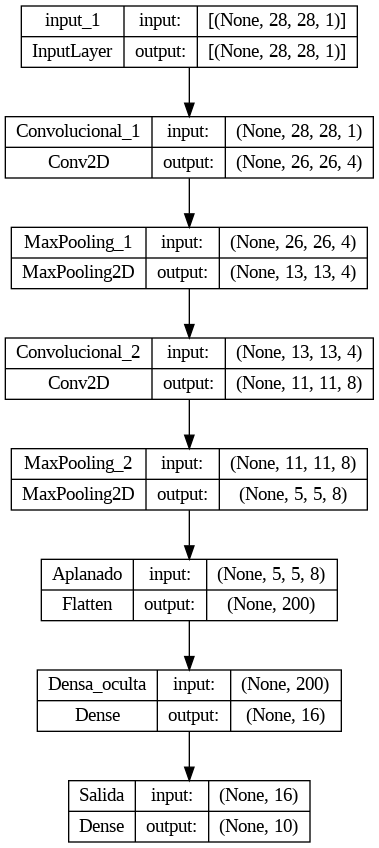

In [ ]:
plot_model(model, "esquema.png", show_shapes=True,
           # dpi=200 # para una mayor resolución
          )

Observamos que, por ejemplo, la primera capa convolucional, que toma como entrada una imagen en blanco y negro de 28x28 píxeles, da como salida una imagen de 26x26 píxeles con 4 canales, es decir, 4 valores por píxel.
Esto se puede interpretar también como 4 imágenes en blanco y negro, cada una de ellas con 26x26 píxeles.

Lo siguiente que especificaremos serán los callbacks, que son operaciones que serán lanzadas en el transcurso del entrenamiento de la red.
El primero de ellos es un ModelCheckpoint, que al final de cada época graba a fichero los pesos de la red si la métrica que le indiquemos ha obtenido el mejor valor hasta el momento.
En nuestro caso, monitorizaremos el loss en validación.
Por tanto, al final del proceso de entrenamiento tendremos en fichero los pesos de la red con mejor métrica en
validación durante este proceso.
El segundo callback que definiremos será el EarlyStopping, que detiene el entrenamiento de la red si hay varias épocas seguidas
sin que mejore la métrica que le indiquemos.
En nuestro caso, queremos que el entrenamiento se detenga si durante cinco épocas no se produce una mejora en el loss de validación.

In [ ]:
lista_callbacks = [
    keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=5,
    ),
    keras.callbacks.ModelCheckpoint(
        filepath="best_model.keras",
        monitor="val_loss",
        save_best_only=True,
    )
]

A continuación, entrenamos la red durante un máximo de 50 épocas, ya que el entrenamiento se podría detener por el callback de early stopping.
La salida de la llamada a model.fit la recogemos en la variable “historia”, que contendrá la evolución en el proceso de entrenamiento de las diferentes métricas.

In [ ]:
historia = model.fit(X_tr, y_tr, epochs=50, batch_size=64,
                     callbacks=lista_callbacks,
                     validation_data=(X_va, y_va))

Epoch 1/50
657/657 [==============================] - 19s 27ms/step - loss: 0.7661 - accuracy: 0.7604 - val_loss: 0.3497 - val_accuracy: 0.8920
Epoch 2/50
657/657 [==============================] - 17s 25ms/step - loss: 0.2224 - accuracy: 0.9314 - val_loss: 0.1809 - val_accuracy: 0.9453
Epoch 3/50
657/657 [==============================] - 19s 29ms/step - loss: 0.1641 - accuracy: 0.9490 - val_loss: 0.1350 - val_accuracy: 0.9595
Epoch 4/50
657/657 [==============================] - 17s 25ms/step - loss: 0.1367 - accuracy: 0.9577 - val_loss: 0.1291 - val_accuracy: 0.9601
Epoch 5/50
657/657 [==============================] - 16s 25ms/step - loss: 0.1194 - accuracy: 0.9634 - val_loss: 0.1281 - val_accuracy: 0.9614
Epoch 6/50
657/657 [==============================] - 17s 26ms/step - loss: 0.1074 - accuracy: 0.9676 - val_loss: 0.1257 - val_accuracy: 0.9614
Epoch 7/50
657/657 [==============================] - 17s 26ms/step - loss: 0.0982 - accuracy: 0.9694 - val_loss: 0.0939 - val_accuracy:

Ahora representamos gráficamente la evolución del entrenamiento de la red:

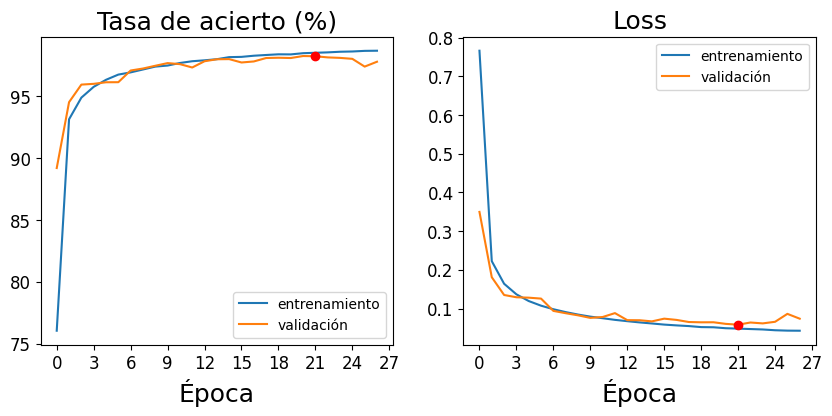

In [ ]:
f = plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
h = historia.history
mejor_epoca = np.argmin(h["val_loss"])
plt.plot(100*np.array(h["accuracy"]),
         label="entrenamiento")
plt.plot(100*np.array(h["val_accuracy"]),
         label="validación")
plt.plot(mejor_epoca, 100*h["val_accuracy"][mejor_epoca], "or")
plt.title("Tasa de acierto (%)", fontsize=18)
plt.xlabel("Época", fontsize=18)
plt.xticks(fontsize=12); plt.yticks(fontsize=12)
plt.legend()
f.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
plt.subplot(1,2,2)
plt.plot(h["loss"], label="entrenamiento")
plt.plot(h["val_loss"], label="validación")
plt.plot(mejor_epoca, h["val_loss"][mejor_epoca], "or")
plt.title("Loss", fontsize=18)
plt.xlabel("Época", fontsize=18)
plt.xticks(fontsize=12); plt.yticks(fontsize=12)
plt.legend()
f.gca().xaxis.set_major_locator(MaxNLocator(integer=True));

Como podemos ver en las gráficas, se han entrenado menos épocas que las 50 inicialmente programadas, ya que el mecanismo de parada temprana (early stopping) ha detenido el proceso al haber detectado que la tasa de acierto en validación no mejoraba durante 5 épocas seguidas.
Por otra parte, el punto rojo está marcando la época en la que se ha obtenido un mejor loss en validación.
Recordemos que en el fichero tenemos los pesos de la red en ese momento.
Los recuperamos:

In [ ]:
model = keras.models.load_model("best_model.keras")

Y ahora lanzaremos la predicción en las dos primeras imágenes de test:

In [ ]:
model.predict(X_te[:2]).round(3)

1/1 [==============================] - 0s 110ms/step


array([[0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)

Como vemos, cada una de las dos predicciones consta de diez números que sumados dan uno.
Estas son las probabilidades de que la clase sea uno u otro dígito.
Ahora sacamos la tasa de acierto en los diferentes conjuntos:

In [ ]:
y_tr_p = np.argmax(model.predict(X_tr), axis=1) 
acc_tr = 100*np.mean(y_tr==y_tr_p) 
print("Accuracy en training: {:.2f}%".format(acc_tr)) 

1313/1313 [==============================] - 8s 6ms/step
Accuracy en training: 98.80%


In [ ]:
y_va_p   = np.argmax(model.predict(X_va), axis=1)
acc_va = 100*np.mean(y_va == y_va_p)
print("Accuracy en validación: {:.2f}%".format(acc_va))

563/563 [==============================] - 4s 8ms/step
Accuracy en validación: 98.24%


In [ ]:
y_te_p   = np.argmax(model.predict(X_te), axis=1)
acc_te = 100*np.mean(y_te == y_te_p)
print("Accuracy en test: {:.2f}%".format(acc_te))

313/313 [==============================] - 2s 6ms/step
Accuracy en test: 98.09%


Finalmente mostraremos la salida de cada una de las capas de la red en la etapa de extracción de características para una imagen de entrada de test:

Entrada:


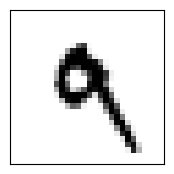

1/1 [==============================] - 0s 73ms/step
Salida capa Convolucional_1 (4 canales):


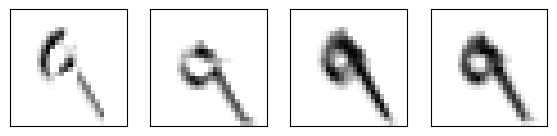

Salida capa MaxPooling_1 (4 canales):


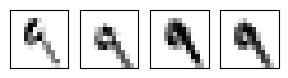

Salida capa Convolucional_2 (8 canales):


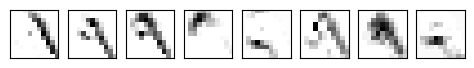

Salida capa MaxPooling_2 (8 canales):


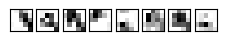

In [ ]:
i = 7
ejemplo = X_te[i:(i+1)]

print("Entrada:")
plt.figure(figsize=(2,2))
plt.imshow(ejemplo[0], cmap="gray_r")
plt.xticks([]); plt.yticks([])
plt.show()

salidas_capas = [capa.output for capa in model.layers[:4]]
nombres_capas = [capa.name for capa in model.layers[:4]]
model_aux = keras.models.Model(inputs=model.input, outputs=salidas_capas)
activaciones = model_aux.predict(ejemplo)
for a,nom in zip(activaciones,nombres_capas):
  s = a.shape[1]/15
  n_canales = a.shape[-1]
  print("Salida capa {} ({} canales):".format(nom,n_canales))
  plt.figure(figsize=(s*n_canales,s))
  for i in range(n_canales):
    plt.subplot(1,n_canales,i+1)
    plt.imshow(a[0,:,:,i], cmap="gray_r")
    plt.xticks([]); plt.yticks([])
  plt.show()